# Moran's tests
Master thesis of Nikolai Popov, MAE-2025

In [1]:
# Libraries import
import pandas as pd # dataframes
import numpy as np # for matrices/vectors
import warnings # to supress warninings
warnings.simplefilter(action='ignore', category=Warning)
from scipy.spatial import distance_matrix # for distance matrix creation
import geopandas as gpd # to read shape files
from scipy.sparse import load_npz, diags # to download the W_N and make diagp - to build diagonal matrices
from libpysal.weights import WSP # to work with sparse inputs
# import esda #
from esda.moran import Moran # for Moran's test
import matplotlib.pyplot as plt # for plots
import statsmodels.formula.api as smf #estimate regression models using R-style formulas
import re # for regular expressions

Load the data.

In [2]:
balanced_df = pd.read_csv("C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/Cleaned_datasets/balanced_dataset_file_collab.csv", 
                          sep=",", on_bad_lines="skip", low_memory=False)

W_N_sparse = load_npz("C:/Users/Popov/Documents/Research/Volchkova_thesis/Data/Cleaned_datasets/W_N_sparse.npz")

Moran’s tests by Year for "Capital" and "Output"

At first, we might make W_N row-normalized (specifically for Moran's tests). But the identification strategy suugest tha we don't.

In [3]:
# # Row-standardize the matrix
# row_sums = np.array(W_N_sparse.sum(axis=1)).flatten()
# row_inv = 1.0 / row_sums
# D_inv = diags(row_inv)
# W_row_std = D_inv.dot(W_N_sparse)

# Convert to PySAL weights object 
# w_pysal = WSP(W_row_std)
w_pysal = WSP(W_N_sparse)

Now to the tests themselves.

In [4]:
# Moran's test for Capital, Output, and Labor for each year
w_standard = w_pysal.to_W()
results = []

for var in ["Capital", "Output", "Labor"]:  # Added "Labor"
    print(f"\n--- Moran's I for {var} ---")
    
    for year in sorted(balanced_df['Year'].unique()):
        y_t = balanced_df[balanced_df['Year'] == year][var].values

        if np.isnan(y_t).any():
            print(f"Skipping year {year} due to missing values.")
            continue

        # Use transformation="O" for defined W
        moran = Moran(y_t, w_standard, transformation="O", permutations=9999) # p-value grid is 1/1000 = 0.001

        print(f"Year {year} | Moran's I: {moran.I:.4f} | p-value: {moran.p_sim:.4f}")

        results.append({
            'variable': var,
            'year': year,
            'moran_i': moran.I,
            'p_value': moran.p_sim
        })

results_df = pd.DataFrame(results)


--- Moran's I for Capital ---
Year 2011 | Moran's I: 0.0079 | p-value: 0.0001
Year 2012 | Moran's I: 0.0079 | p-value: 0.0001
Year 2013 | Moran's I: 0.0110 | p-value: 0.0001
Year 2014 | Moran's I: 0.0112 | p-value: 0.0001
Year 2015 | Moran's I: 0.0106 | p-value: 0.0001
Year 2016 | Moran's I: 0.0106 | p-value: 0.0001

--- Moran's I for Output ---
Year 2011 | Moran's I: 0.0028 | p-value: 0.0009
Year 2012 | Moran's I: 0.0074 | p-value: 0.0001
Year 2013 | Moran's I: 0.0149 | p-value: 0.0001
Year 2014 | Moran's I: 0.0167 | p-value: 0.0001
Year 2015 | Moran's I: 0.0159 | p-value: 0.0001
Year 2016 | Moran's I: 0.0158 | p-value: 0.0001

--- Moran's I for Labor ---
Year 2011 | Moran's I: 0.0087 | p-value: 0.0001
Year 2012 | Moran's I: 0.0124 | p-value: 0.0001
Year 2013 | Moran's I: 0.0159 | p-value: 0.0001
Year 2014 | Moran's I: 0.0166 | p-value: 0.0001
Year 2015 | Moran's I: 0.0159 | p-value: 0.0001
Year 2016 | Moran's I: 0.0124 | p-value: 0.0001


In [5]:
results_df

,variable,year,moran_i,p_value
0,Capital,2011,0.007941,0.0001
1,Capital,2012,0.007872,0.0001
2,Capital,2013,0.011020,0.0001
3,Capital,2014,0.011182,0.0001
4,Capital,2015,0.010640,0.0001
5,Capital,2016,0.010611,0.0001
6,Output,2011,0.002833,0.0009
7,Output,2012,0.007398,0.0001
8,Output,2013,0.014947,0.0001
9,Output,2014,0.016691,0.0001


In [6]:
latex_output = results_df.to_latex(
    index=False,
    caption="Moran's Tests",
    label="tab:moran_tests",
    column_format='llrr',
    header=["Variable", "Year", "Moran's I", "p-value"],
    float_format="%.4f"
)

# Print directly in Python output
print(latex_output)

\begin{table}
\caption{Moran's Tests}
\label{tab:moran_tests}
\begin{tabular}{llrr}
\toprule
Variable & Year & Moran's I & p-value \\
\midrule
Capital & 2011 & 0.0079 & 0.0001 \\
Capital & 2012 & 0.0079 & 0.0001 \\
Capital & 2013 & 0.0110 & 0.0001 \\
Capital & 2014 & 0.0112 & 0.0001 \\
Capital & 2015 & 0.0106 & 0.0001 \\
Capital & 2016 & 0.0106 & 0.0001 \\
Output & 2011 & 0.0028 & 0.0009 \\
Output & 2012 & 0.0074 & 0.0001 \\
Output & 2013 & 0.0149 & 0.0001 \\
Output & 2014 & 0.0167 & 0.0001 \\
Output & 2015 & 0.0159 & 0.0001 \\
Output & 2016 & 0.0158 & 0.0001 \\
Labor & 2011 & 0.0087 & 0.0001 \\
Labor & 2012 & 0.0124 & 0.0001 \\
Labor & 2013 & 0.0159 & 0.0001 \\
Labor & 2014 & 0.0166 & 0.0001 \\
Labor & 2015 & 0.0159 & 0.0001 \\
Labor & 2016 & 0.0124 & 0.0001 \\
\bottomrule
\end{tabular}
\end{table}



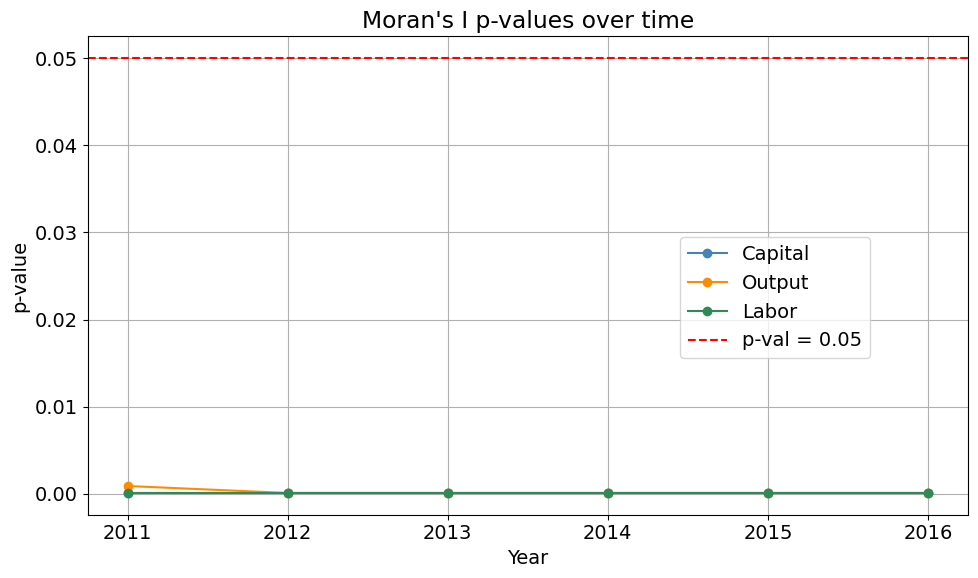

In [7]:
plt.figure(figsize=(10, 6))

# Increase overall font size
plt.rcParams.update({'font.size': 14})

# Custom colors
colors = {
    "Capital": "steelblue",
    "Output": "darkorange",
    "Labor": "seagreen"  # Add Labor with a distinct color
}

# Plot p-values by variable
for var in results_df["variable"].unique():
    subset = results_df[results_df["variable"] == var]
    plt.plot(subset["year"], subset["p_value"], marker='o', label=var, color=colors.get(var, 'gray'))

# Reference line at p = 0.05
plt.axhline(y=0.05, color='red', linestyle='--', label='p-val = 0.05')

# Formatting
plt.xlabel("Year")
plt.ylabel("p-value")
plt.title("Moran's I p-values over time")
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.6))
plt.grid(True)
plt.tight_layout()

# Save the plot
output_dir = "C:/Users/Popov/Documents/Research/Volchkova_thesis/Output"
image_path = f"{output_dir}/Moran_test_plot.png"
plt.savefig(image_path, dpi=1000, bbox_inches='tight')
plt.show()